In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize

## Data Loading and Cleaning

In [2]:
url = "review.json"
df = pd.read_json(url, orient='columns', lines= True)
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [3]:
# reviews with 1,2,3 star ratings = negative, reviews with 4,5 star ratings = positive.

full_set = pd.DataFrame(df)  

full_set.loc[full_set['stars'] == 1, 'sentiment'] = "negative"
full_set.loc[full_set['stars'] == 2, 'sentiment'] = "negative"
full_set.loc[full_set['stars'] == 3, 'sentiment'] = "negative"
full_set.loc[full_set['stars'] == 4, 'sentiment'] = "positive"
full_set.loc[full_set['stars'] == 5, 'sentiment'] = "positive"

full_set['sentiment'].value_counts()

positive    4402067
negative    2283833
Name: sentiment, dtype: int64

For this analysis, we will use 30,000 instances for training and 20,000 instances for testing the model. After we get the accuracy level from this, we will check if using more data makes a significant difference to the accuracy.

In [4]:
# Retrieve and store the first 25,000 of each sentiment (positive and negative)
bin_analysis_set = pd.DataFrame()
bin_analysis_set = full_set.groupby('sentiment').head(25000)
bin_analysis_set['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
export_csv = full_set.to_csv('yelp_subset_reviews_binary.csv',index = None, header = True)

Now we have a dataset with equal number of positive and negative reviews. Let's split this into train and test sets with equal number of both sentiments.

In [14]:
train_set = bin_analysis_set.groupby('sentiment').head(15000)
test_set = bin_analysis_set.groupby('sentiment').tail(10000)

print(train_set['sentiment'].value_counts())
print(test_set['sentiment'].value_counts())

positive    15000
negative    15000
Name: sentiment, dtype: int64
positive    10000
negative    10000
Name: sentiment, dtype: int64


In [15]:
train_set.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36,negative
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33,positive
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03,positive
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38,positive
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38,negative


In [16]:
test_set.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
22589,CASVsvBbfgg3h7N_HhI_Xw,mrqEz7JAM20iJAWp62vpjw,c_iQzwsTDYraPvHSKz88QA,5,0,0,0,This was the best candy store of all time. The...,2014-04-02 05:25:21,positive
22591,IJnRys0Rl1FaFRvEWkhLog,tzCNZD_I-46eSHGpf3b9mQ,6xgcHeLad-VaoTIQewK84A,5,0,0,0,"Amazing, amazing, amazing food. I ordered the ...",2011-07-30 00:14:40,positive
22594,Qtr9H6iwG1LcwCgpNnGf7g,KmSrtnyJqj9QLe5FTwuNgQ,w4HGeKuWh8_xExReeid2zQ,4,0,0,0,This is my absolute favorite place for a\nPedi...,2015-05-26 23:32:24,positive
22595,p16T5W7qWy9Ws1rUQuJarQ,1mzoD1rhO7McksZD3BWbZg,bGno_WKbepp48eqgUfRHMA,5,0,0,0,We found this place on a whim while looking fo...,2018-05-09 01:23:26,positive
22596,s-ahLZRBLtm2BN65e2fTtQ,_HyT6uRsg8PbCd7nuJA0fA,WDKTg468bkRPW0LqbAZfmg,5,0,0,0,This is definitely a great spot to start the n...,2014-04-02 09:22:48,positive


## Model: Support Vector Machine 

Reference: https://www.kaggle.com/lbronchal/sentiment-analysis-with-svm

First I'm splitting the train and test datasets into 4 arrays:\
X_train: contains the reviews from the train dataset\
X_test: contains the reviews from the test dataset\
y_train: contains the sentiment values from the train dataset\
y_test: contains the sentiment values from the train dataset

In [17]:
X_train = train_set['text'].values
X_test = test_set['text'].values
y_train = train_set['sentiment']
y_test = test_set['sentiment']

### Removing stopwords
We will now remove stop words. These are the commonly occuring words in the english language that are not going to be useful for our analysis.\
e.g: 'a', 'to', 'and', 'I' etc.\
### Defining the vectorizer
ngram_range represents the number of words that are counted together. For example, if the sentence is "An apple a day keeps the doctor away", removal of stopwords makes it "apple day keeps doctor away".\
Unigram: 'apple', 'day, 'keeps','doctor','away'\
Bigram: takes two words at a time: 'apple day', 'day keeps', 'keeps doctor', 'doctor away'\
For this example, let's keep the words as unigrams.

In [18]:
#removing the stopwords

def tokeniser(text, is_lower_case=False):
    return nltk.word_tokenize(text)

stop_words_english =set(stopwords.words('english'))

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokeniser,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = stop_words_english)

In [20]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

np.random.seed(1)

#Takes vectoriser and the classifier (SVC) 
pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 82.2min finished
/Users/jahnavi/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.938951205

The svc__C value is given as 0.01. Other values can also be tried to determine the one that yields the best acuracy.

In [21]:
print("Best params: " + str(grid_svm.best_params_))
print("Best Score: " + str(grid_svm.best_score_))

Best params: {'svc__C': 0.01}
Best Score: 0.9409821888888888


In [23]:
grid_svm.classes_

array(['negative', 'positive'], dtype=object)

The classes are in the order as shows above - first 'negative' and then 'positive'. List them in the same order for the 'target_names' parameter.

In [24]:
model = grid_svm.best_estimator_
pred_proba = model.predict_proba(X_test)[:, 1]
pred = model.predict(X_test)        

class_report=classification_report(y_test,pred,target_names=['negative','positive'])

print(class_report)
print(pred_proba)

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87     10000
    positive       0.87      0.88      0.87     10000

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

[8.34978099e-01 9.97169966e-01 9.96423493e-01 ... 7.16657250e-01
 6.46452809e-01 7.36595887e-04]


#### According to the classification report, the accuracy for negative and positive reviews are similar (precision) as is the recall rate. These means the model is being trained on positive and negative reviews equally well, without any bias. This may be accredited to the fact that the classes are perfectly balanced in the dataset.

Precision of negative = true negative / (true negative + false negative)\
Precision of negative = true positive / (true positive + false positive)\
Recall of negative = true negative / (true negative + false positive)\
Recall of positive = true positive / (true positive + false negative)

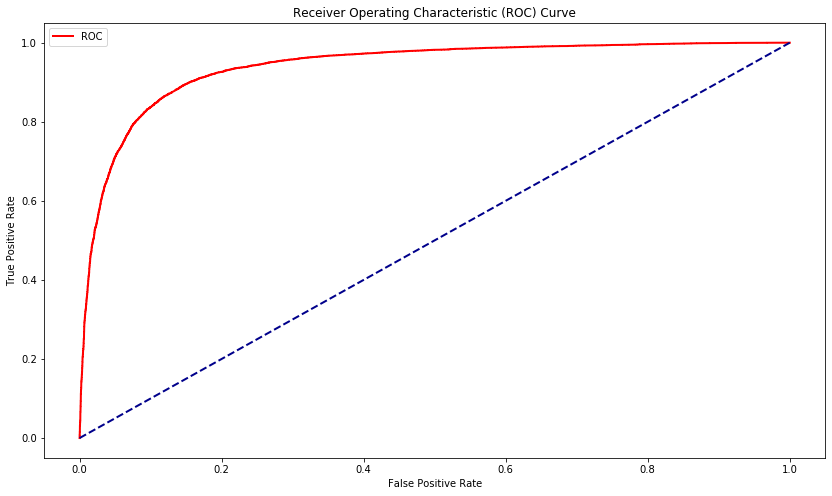

In [25]:
fpr, tpr, threshold = roc_curve(y_test, pred_proba, pos_label = 'positive')
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color='red', label='ROC', lw = 2)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', lw = 2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

1. **pos_label**: needs to be specified when y_test doesnt include binary values {0,1}. Set it's value to the positive class in the dataset.
2. The second parameter into the roc_curve function needs to be an array of **probability values**, not the actual classfication by the model (i.e. either 'positive' or 'negative'). Instead of 'pred', pass in 'pred_proba'.

In [ ]:
np.unique(y_train)
print(y_train.shape)
print(y_train)

/Users/jahnavi/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


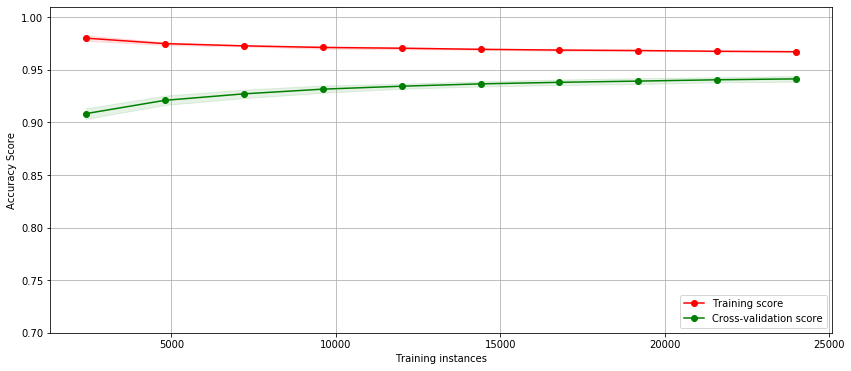

In [26]:
train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", shuffle = True, train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training instances")
    plt.ylabel("Accuracy Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()



fill_between(x,y1,y2) plots points (x,y1) and (x,y2). If you look at the green graph, the graph is filled in.
The bottom point is (train_sizes, train_scores_mean - train_scores_std) and the top point is
(train_sizes, train_scores_mean + train_scores_std). The bold line in the middle is the mean.
This implies that there is more variation in the test values from the mean, than in the train set.
There is no major variance problem.

From the two graphs, there is not a lot of difference between train and test set accuracy (train ~97% and test ~93%)
This implies there isn't a large bias problem.
As the accuracy slopes up as the number of training instances is increased, it shows that the test model performed
better as it got more and more data.

## Prediction of actual reviews

I took some random reviews from Yelp and ran it through the model to predict if it was a positive or negative review. Here are some of the results.

In [27]:
grid_svm.predict(["Friday at opening for lunch and all but 2 seats were taken.  Staff was friendly, but a bit aloof at times.  Food was terrific.  If all vegan food could be this fresh and tasty, with quality ingredients.  We ordered the nachos and the po'boy - both hit the spot and were tastier than meat versions we had in the surrounding area!  Portions are generous."])
# grid_svm.predict([""])


array(['positive'], dtype=object)

In [35]:
grid_svm.predict(["This place is soooooooo slow. Placed our order and waited 45 minutes. Nobody comes around to \
update you. Went to the kitchen and asked about our food. Was told we had to wait another 10 minutes. Simply left."])


array(['negative'], dtype=object)

In [29]:
grid_svm.predict(["Group on hit! I purchased this he group on deal to take my daughter to an organic vegan place as \
we got burned out on Veggie Grill together as we have gone often. This vegan spot a little different! Not everything\
taste wise runs together and eventually tastes the same which many vegetarian places seem to follow,The burger and\
the salad did not taste the same and were really good! The people here are friendly and the atmosphere is pleasant.\
I will go back next year and see what's new on the menu. I recommend for  vegan seekers for sure!"])

array(['positive'], dtype=object)

In [30]:
grid_svm.predict(["You'd better like fried food. It's pretty much vegan bar food without much on the creative side.\
The black beans were ok but have a kind of pasty mouth feel. They could get a waffle right so the wife came home \
and ate cereal. Service was ok, but be prepared to wait after you order..."])

array(['negative'], dtype=object)

In [32]:
grid_svm.predict_proba(["You'd better like fried food. It's pretty much vegan bar food without much on the creative \
side. The black beans were ok but have a kind of pasty mouth feel. They could get a waffle right so the wife came home\
and ate cereal. Service was ok, but be prepared to wait after you order..."])
# array([[negative, positive]])

array([[0.92346837, 0.07653163]])

In [33]:
grid_svm.predict_proba(["Group on hit! I purchased this he group on deal to take my daughter to an organic vegan place\
as we got burned out on Veggie Grill together as we have gone often. This vegan spot a little different! Not \
everything taste wise runs together and eventually tastes the same which many vegetarian places seem to follow,\
The burger and the salad did not taste the same and were really good! The people here are friendly and the atmosphere\
is pleasant. I will go back next year and see what's new on the menu. I recommend for  vegan seekers for sure!"])


array([[0.05081907, 0.94918093]])

In [34]:
grid_svm.predict_proba(["Group on hit! I purchased this he group on deal to take my daughter to an organic vegan place\
as we got burned out on Veggie Grill together as we have gone often. This vegan spot a little different! Not \
everything taste wise runs together and eventually tastes the same which many vegetarian places seem to follow,\
The burger and the salad did not taste the same and were really good! The people here are friendly and the atmosphere\
is pleasant. I will go back next year and see what's new on the menu. I recommend for  vegan seekers for sure!"])[0][1]
# always outputs positive probability

0.9491809291139116

In [ ]:
----------------------------------------------------------------------------------------------------------------------

## Model: Näive Bayes

Reference: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

In [36]:
train_set_mult = pd.DataFrame(train_set)
test_set_mult = pd.DataFrame(test_set)


In [37]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
train_set_mult['text'] = train_set_mult['text'].apply(clean_text)
test_set_mult['text'] = test_set_mult['text'].apply(clean_text)

#print_plot(10)

In [38]:
test_set_mult['text'].apply(lambda x: len(x.split(' '))).sum()

1180504

In [39]:
X_train_mult = train_set_mult['text'].values
X_test_mult = test_set_mult['text'].values
y_train_mult = train_set_mult['sentiment']
y_test_mult = test_set_mult['sentiment']

In [40]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train_mult, y_train_mult)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [41]:
tags = ['negative', 'positive']
y_pred_mult = nb.predict(X_test_mult)
y_pred_prob_mult = nb.predict_proba(X_test_mult)[:, 1]

print('accuracy %s' % accuracy_score(y_pred_mult, y_test_mult))
print(classification_report(y_test_mult, y_pred_mult,target_names=tags))

accuracy 0.8451
              precision    recall  f1-score   support

    negative       0.82      0.88      0.85     10000
    positive       0.87      0.81      0.84     10000

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.84     20000
weighted avg       0.85      0.85      0.84     20000



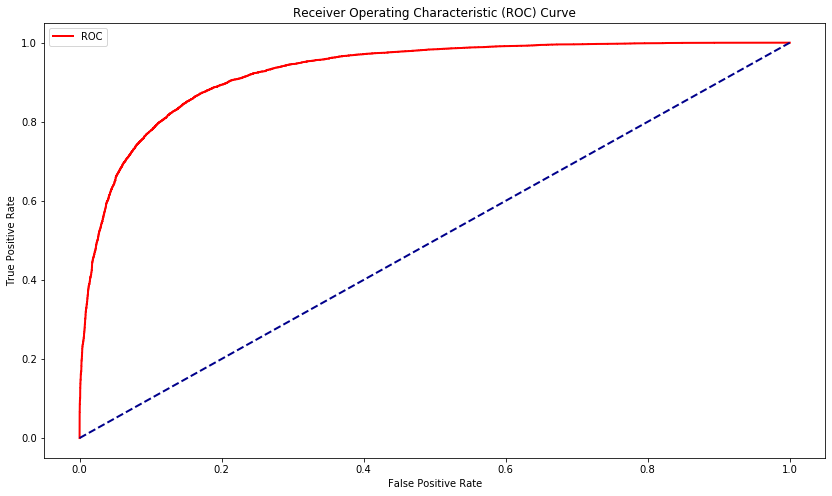

In [42]:
fpr, tpr, threshold = roc_curve(y_test_mult, y_pred_prob_mult, pos_label = 'positive')
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color='red', label='ROC', lw = 2)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', lw = 2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

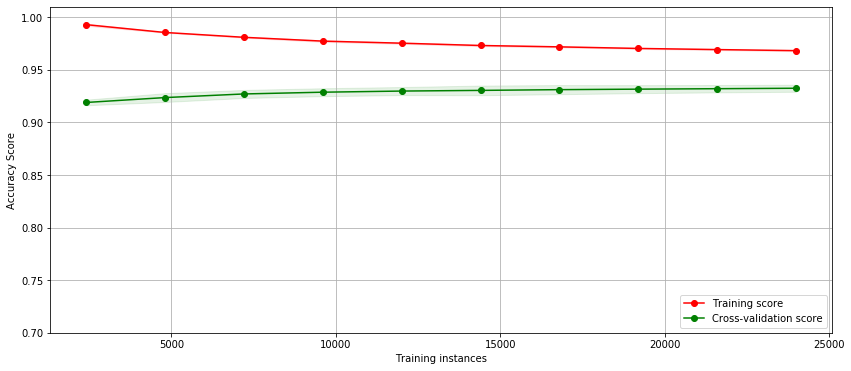

In [45]:
train_sizes, train_scores, test_scores = \
    learning_curve(nb, X_train_mult, y_train_mult, cv=5, n_jobs=-1, 
                   scoring="roc_auc", shuffle = True, train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training instances")
    plt.ylabel("Accuracy Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

plot_learning_curve(X_train_mult, y_train_mult, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()


The accuracy increased with increase in the number of training instances, however there was also an increase in the amount of variation (see filled in part of the line).

In [46]:
nb.predict(["the food was disgusting and service was bad."])

array(['negative'], dtype='<U8')

In [ ]:
----------------------------------------------------------------------------------------------------------------------

## Model: Logistic Regression

In [47]:
X_train_log = train_set_mult['text'].values
X_test_log = test_set_mult['text'].values
y_train_log = train_set_mult['sentiment']
y_test_log = test_set_mult['sentiment']

In [49]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=1100)),
               ])
logreg.fit(X_train_log, y_train_log)

y_pred_log = logreg.predict(X_test_log)
y_pred_prob_log = logreg.predict_proba(X_test_log)[:, 1]

print('accuracy %s' % accuracy_score(y_pred_log, y_test_log))
print(classification_report(y_test_log, y_pred_log,target_names=tags))

accuracy 0.83385
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83     10000
    positive       0.83      0.83      0.83     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



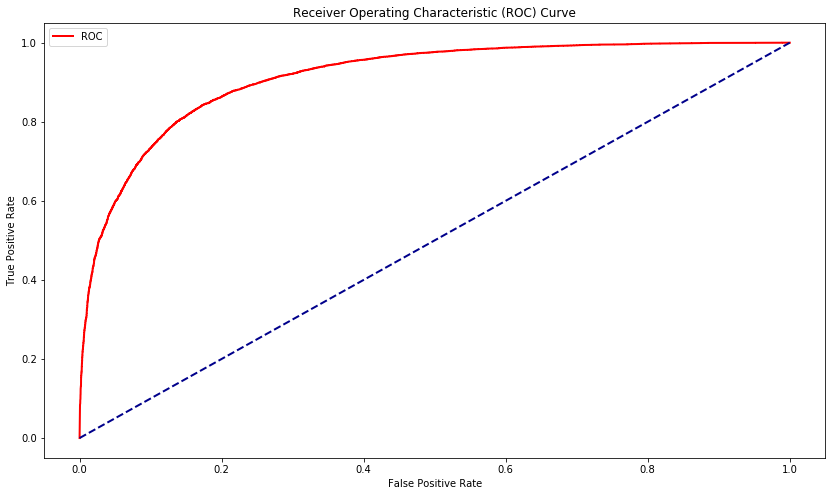

In [50]:
fpr, tpr, threshold = roc_curve(y_test_log, y_pred_prob_log, pos_label = 'positive')
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color='red', label='ROC', lw = 2)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', lw = 2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

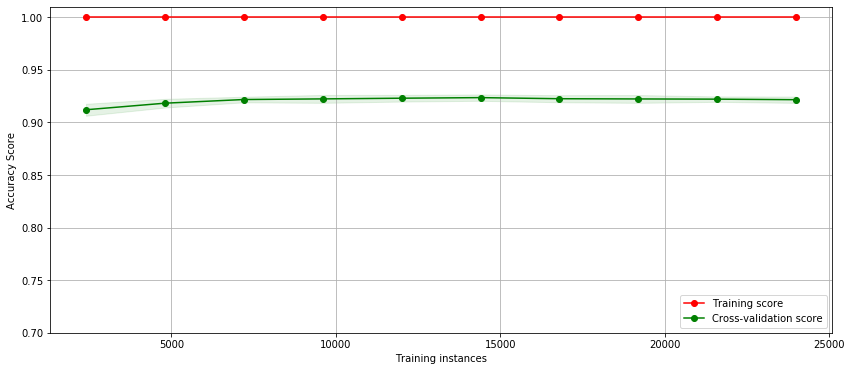

In [51]:
train_sizes, train_scores, test_scores = \
    learning_curve(logreg, X_train_log, y_train_log, cv=5, n_jobs=-1, 
                   scoring="roc_auc", shuffle=True, train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training instances")
    plt.ylabel("Accuracy Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

plot_learning_curve(X_train_log, y_train_log, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()


The accuracy improved slightly with the increase in amount of data, but started to steady towards the end. Adding more training instances could decrease the accuracy!

In [53]:
logreg.predict(["This place is soooooooo slow.Placed our order and waited 45 minutes. Nobody comes around to update \
you. Went to the kitchen and asked about our food. Was told we had to wait another 10 minutes. Simply left."])


array(['negative'], dtype=object)

In [ ]:
----------------------------------------------------------------------------------------------------------------------

## Model: Logistic Regression with additional 'neutral' category'

I ran the Logistic Regression model with another category added - 'neutral' for 3 star reviews. I expected the overall accuracy to decrease, however it is important to have the differentiation between positive/negative and neutral reviews.

In [54]:
train_set['stars'].value_counts()

5    10073
1     6549
4     4927
3     4915
2     3536
Name: stars, dtype: int64

In [55]:
train_set_bal = pd.DataFrame()

train_set_bal = df.groupby('stars').head(6000)
train_set_bal['stars'].value_counts()

5    6000
4    6000
3    6000
2    6000
1    6000
Name: stars, dtype: int64

In [56]:
test_set_bal = pd.DataFrame()

test_set_bal = df.groupby('stars').head(6000)
test_set_bal['stars'].value_counts()

5    6000
4    6000
3    6000
2    6000
1    6000
Name: stars, dtype: int64

TF  = (Frequency of a word in the document)/(Total words in the document)

IDF = Log((Total number of docs)/(Number of docs containing the word))

In [57]:
full_set = pd.DataFrame(df)

full_set.loc[full_set['stars'] == 1, 'sentiment'] = "negative"
full_set.loc[full_set['stars'] == 2, 'sentiment'] = "negative"
full_set.loc[full_set['stars'] == 3, 'sentiment'] = "neutral"
full_set.loc[full_set['stars'] == 4, 'sentiment'] = "positive"
full_set.loc[full_set['stars'] == 5, 'sentiment'] = "positive"

full_set['sentiment'].value_counts()

positive    4402067
negative    1544553
neutral      739280
Name: sentiment, dtype: int64

Categories are not balanced: there will be a bias towards positive reviews.

In [ ]:
export_csv = full_set.to_csv('yelp_subset_reviews.csv',index = None, header = True)

In [58]:
analysis_set = pd.DataFrame()
analysis_set = full_set.groupby('sentiment').head(20000)
analysis_set['sentiment'].value_counts()

positive    20000
negative    20000
neutral     20000
Name: sentiment, dtype: int64

In [59]:
analysis_set.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36,negative
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33,positive
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03,positive
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38,positive
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38,negative


In [60]:
train_set_det = analysis_set.groupby('sentiment').head(10000)
test_set_det = analysis_set.groupby('sentiment').tail(10000)

In [62]:
train_set_det['text'] = train_set_det['text'].apply(clean_text)
test_set_det['text'] = test_set_det['text'].apply(clean_text)

/Users/jahnavi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jahnavi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
X_train_det = train_set_det['text'].values
X_test_det = test_set_det['text'].values
y_train_det = train_set_det['sentiment']
y_test_det = test_set_det['sentiment']


In [64]:
vectorizer_det = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
vectorizer_det.fit_transform(X_train_det)
vectorizer_det.fit_transform(X_test_det)

<30000x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 1229677 stored elements in Compressed Sparse Row format>

### Logistic Regression

In [66]:
# Logistic Regression - Without the pipeline.

X = vectorizer_det.transform(X_train_det)
X_test_det_trans = vectorizer_det.transform(X_test_det)

final_ngram = LogisticRegression(C=0.5, max_iter=1200)
final_ngram.fit(X, y_train_det)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test_det, final_ngram.predict(X_test_det_trans)))

Final Accuracy: 0.7501666666666666


### Random Forest

In [67]:
# Random Forest - with pipeline

rf = Pipeline([('vect', TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))),
                ('rf', RandomForestClassifier(n_estimators=200, random_state=0))
               ])

parameters = {
    'vect__max_df': [0.6],
    'vect__max_features': [2500],
    'vect__ngram_range': [(1, 1)],
}

grid_search = GridSearchCV(rf, parameters, n_jobs=-1, verbose=1)

grid_search.fit(X_train_det, y_train_det)
predictions = grid_search.predict(X_test_det)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [68]:
print(confusion_matrix(y_test_det,predictions))
print(classification_report(y_test_det,predictions))
print(accuracy_score(y_test_det, predictions))

[[7437 2063  500]
 [1808 6486 1706]
 [ 724 2012 7264]]
              precision    recall  f1-score   support

    negative       0.75      0.74      0.74     10000
     neutral       0.61      0.65      0.63     10000
    positive       0.77      0.73      0.75     10000

    accuracy                           0.71     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.71      0.71      0.71     30000

0.7062333333333334


#### Prediction on random 3-star review from yelp

In [69]:
grid_search.predict(["You'd better like fried food. It's pretty much vegan bar food without much on the creative \
side. The black beans were ok but have a kind of pasty mouth feel. They could get a waffle right so the wife came home\
and ate cereal. Service was ok, but be prepared to wait after you order..."]) # correctly predicted by NB.

array(['neutral'], dtype=object)

In [70]:
grid_search.predict_proba(["You'd better like fried food. It's pretty much vegan bar food without much on the creative \
side. The black beans were ok but have a kind of pasty mouth feel. They could get a waffle right so the wife came home\
and ate cereal. Service was ok, but be prepared to wait after you order..."]) # predicted with probability 0.56

array([[0.3  , 0.565, 0.135]])